In [17]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os
import math

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('legend', title_fontsize=10)
plt.rc('figure', titlesize=10)

plt.rc('legend', framealpha=0.0)
plt.rc('lines', linewidth=1.5)

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'
plt.rcParams['font.family'] = "Times New Roman"
# plt.rcParams['font.serif'] = ['Computer Modern']

matplotlib.rcParams['figure.figsize'] = (textwidth := 5.5, 2.0)
matplotlib.rcParams['figure.dpi'] = 150

colorize = lambda dim_list, colormap : [colormap(i) for i in np.linspace(0.0, 0.92, len(dim_list))]

In [40]:
def get_run(dataset, arch, optim, normalize, width, depth, key, wd=True, verbose=False):
    logdir = os.path.join("..","logs","" if wd else "no_wd",dataset,arch,optim,normalize,str(width),str(depth))
    
    if optim == "adam" and normalize != "normalize":
#         lr_list = [0.00012207031, 0.00024414062, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]        
        lr_list = [0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]
#     elif dataset == "shakespeare" and normalize == "normalize":
#         lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
    else:
        lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]
    
    returned_result_list = []
    returned_lr_list = []
    
    for lr in lr_list:
        try:
            with open(os.path.join(logdir, str(lr), 'results.pickle'), "rb") as file:
                results = pickle.load(file)[key]
            average_result = np.mean(results[-50:])
            returned_result_list.append(average_result)
            returned_lr_list.append(lr)
        except:
            if verbose:
                print(f"warning: missing {optim} {normalize} width={width} depth={depth} lr={lr}")
                
        try:
            with open(os.path.join(logdir, str(lr), 'args.pickle'), "rb") as file:
                args = pickle.load(file)
        except:
            args = {}
    
    return returned_lr_list, returned_result_list, args

# ResMLP sweeps

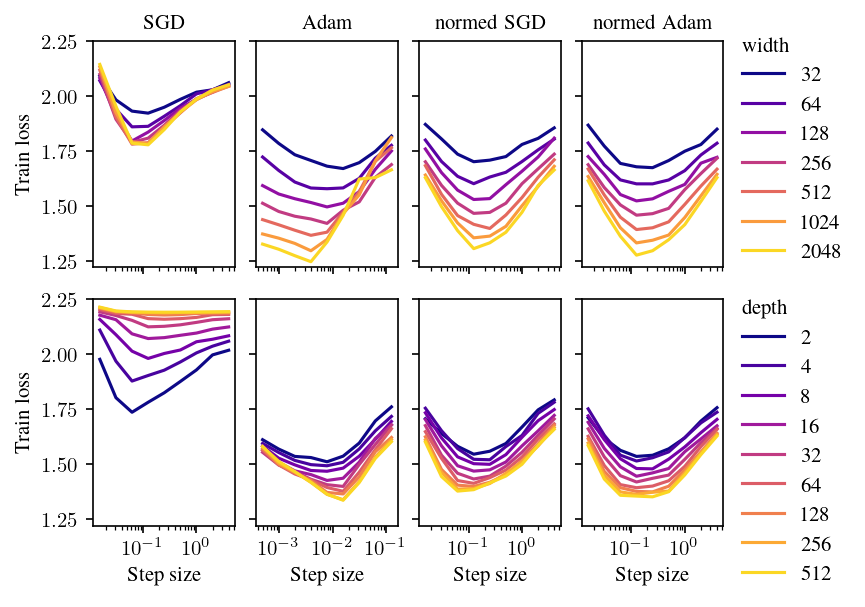

In [4]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128

dataset = "cifar10"
arch = "resmlp"
key = "train_loss"

fig, axes = plt.subplots(2, 4, sharey=True)
fig.set_figheight(4)

axis = 0
for normalize in "unnormalize", "normalize":
    for optim in "sgd", "adam":
        for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key)
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            title = "SGD" if optim == "sgd" else "Adam"
            if normalize == "normalize": title = "normed " + title
            axes[0,axis].set_title(title)
        for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key)
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
        axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,3].legend(title="width", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
axes[1,3].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"

axes[0,0].set_ylim(1.22,2.25)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("sweep-resmlp.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

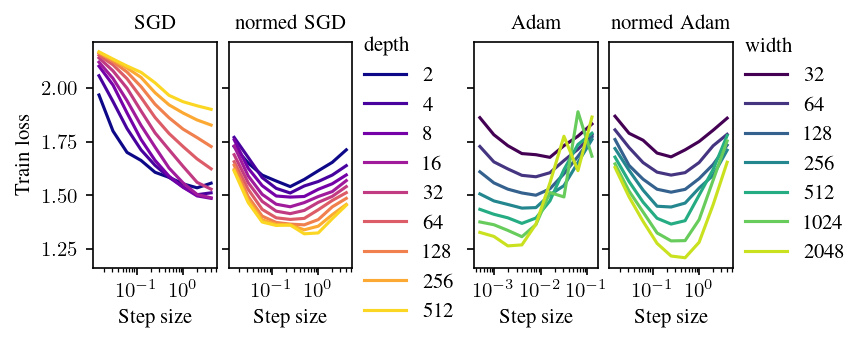

In [25]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128

dataset = "cifar10"
arch = "resmlp"
key = "train_loss"

fig, axes = plt.subplots(1, 5, sharey=True, width_ratios=[1,1,0.8,1,1])
fig.set_figheight(2)

for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
    lr_list, result_list, args = get_run(dataset, arch, "sgd", "unnormalize", this_width, depth, key, wd=False)
    axes[0].plot(lr_list, result_list, color=color, label=depth)
    lr_list, result_list, args = get_run(dataset, arch, "sgd", "normalize", this_width, depth, key, wd=False)
    axes[1].plot(lr_list, result_list, color=color, label=depth)
    
for width, color in zip(width_list, colorize(width_list, plt.cm.viridis)):
    lr_list, result_list, args = get_run(dataset, arch, "adam", "unnormalize", width, this_depth, key, wd=False)
    axes[3].plot(lr_list, result_list, color=color, label=width)
    lr_list, result_list, args = get_run(dataset, arch, "adam", "normalize", width, this_depth, key, wd=False)
    axes[4].plot(lr_list, result_list, color=color, label=width)
    
for axis in axes: 
    axis.set_xscale("log")
    axis.set_xlabel("Step size")
    
axes[0].set_ylabel("Train loss")
    
axes[0].set_title("SGD")
axes[1].set_title("normed SGD")
axes[3].set_title("Adam")
axes[4].set_title("normed Adam")

axes[1].legend(title="depth", bbox_to_anchor=(0.95, 1.10))._legend_box.align = "left"
axes[4].legend(title="width", bbox_to_anchor=(0.95, 1.10))._legend_box.align = "left"

axes[2].axis("off")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
plt.savefig("sweep-summary.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

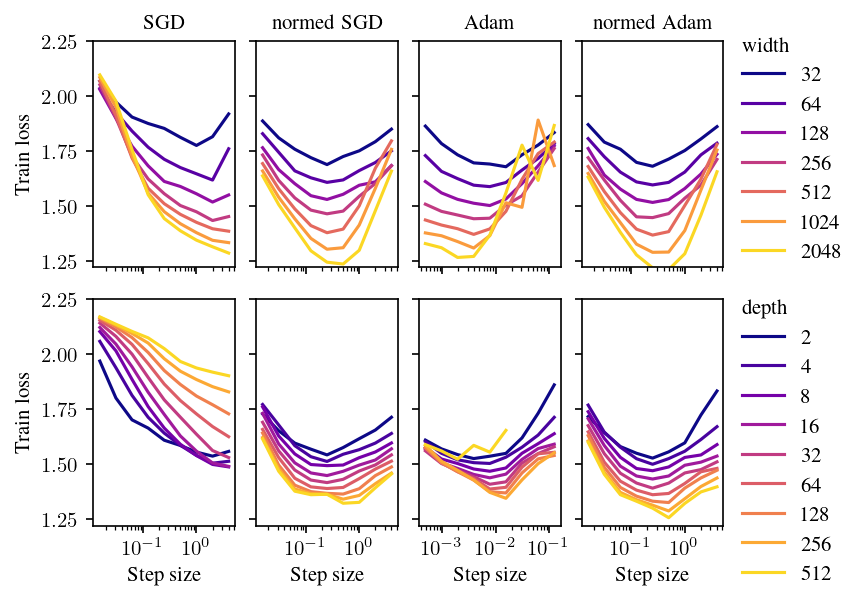

In [6]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128

dataset = "cifar10"
arch = "resmlp"
key = "train_loss"

fig, axes = plt.subplots(2, 4, sharey=True)
fig.set_figheight(4)

axis = 0
for optim in "sgd", "adam":
    for normalize in "unnormalize", "normalize":
        for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, wd=False)
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            title = "SGD" if optim == "sgd" else "Adam"
            if normalize == "normalize": title = "normed " + title
            axes[0,axis].set_title(title)
        for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, wd=False)
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
        axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,3].legend(title="width", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
axes[1,3].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"

axes[0,0].set_ylim(1.22,2.25)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("sweep-resmlp.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

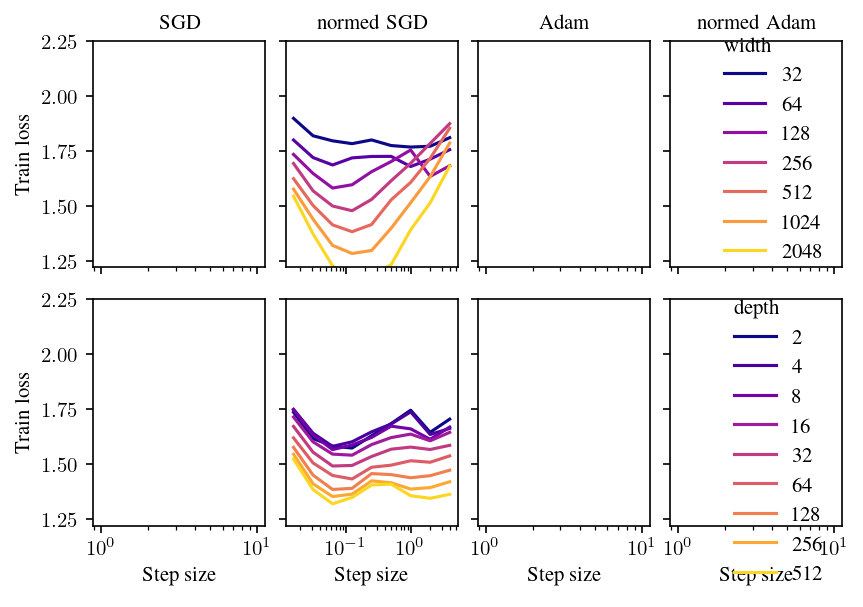

In [3]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128

dataset = "cifar10"
arch = "resmlp"
key = "train_loss"

fig, axes = plt.subplots(2, 4, sharey=True)
fig.set_figheight(4)

axis = 0
for optim in "sgd", "adam":
    for normalize in "unnormalize", "normalize":
        for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, wd=False)
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            title = "SGD" if optim == "sgd" else "Adam"
            if normalize == "normalize": title = "normed " + title
            axes[0,axis].set_title(title)
        for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, wd=False)
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
        axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,3].legend(title="width", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
axes[1,3].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"

axes[0,0].set_ylim(1.22,2.25)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("sweep-resmlp.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]


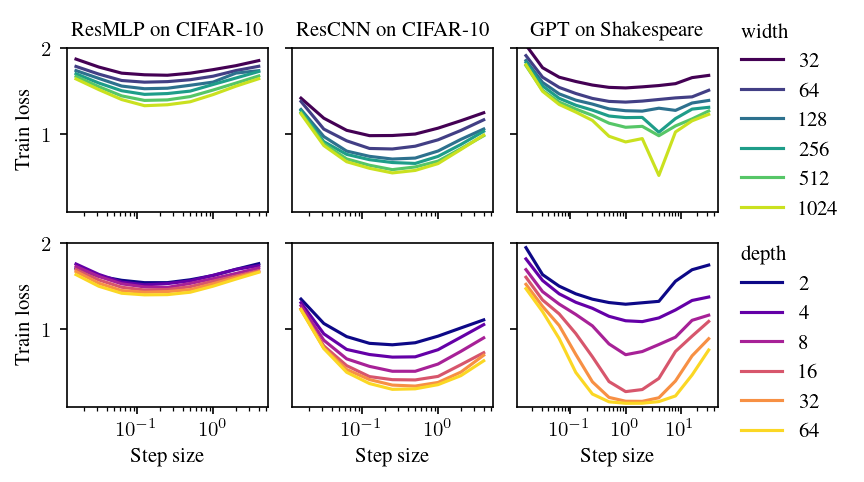

In [30]:
width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

normalize = "normalize"
key = "train_loss"
# key = "train_acc"
optim = "adam"

fig, axes = plt.subplots(2, 3, sharey=True)
fig.set_figheight(3)

axis = 0
for arch, dataset in ("resmlp","cifar10"), ("rescnn", "cifar10"), ("gpt", "shakespeare"):
    for width, color in zip(width_list, colorize(width_list, plt.cm.viridis)):
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, verbose=False)
        if dataset != "shakespeare" or 'num_heads' in args and args['num_heads'] == 8:            
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            if arch == "resmlp": title = "ResMLP"
            elif arch == "rescnn": title = "ResCNN"
            elif arch == "gpt": title = "GPT"
            title += " on "
            if dataset == "cifar10": title += "CIFAR-10"
            elif dataset == "shakespeare": title += "Shakespeare"
            axes[0,axis].set_title(title)
    for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, verbose=False)
        if dataset != "shakespeare" or 'num_heads' in args and args['num_heads'] == 8:
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
            if dataset == "shakespeare": print(lr_list)
    axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,2].legend(title="width", bbox_to_anchor=(1.705,  1.27))._legend_box.align = "left"
axes[1,2].legend(title="depth", bbox_to_anchor=(1.6,  1.1))._legend_box.align = "left"

axes[0,0].set_ylim(0.1,2.0)

plt.tight_layout(w_pad=0.8, pad=0.0)
plt.savefig("sweep-arch.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

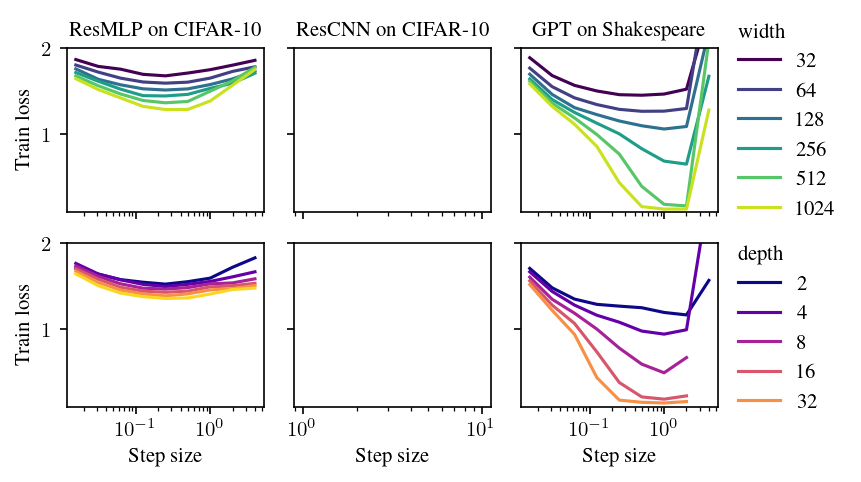

In [41]:
width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

normalize = "normalize"
key = "train_loss"
# key = "train_acc"
optim = "adam"

fig, axes = plt.subplots(2, 3, sharey=True)
fig.set_figheight(3)

axis = 0
for arch, dataset in ("resmlp","cifar10"), ("rescnn", "cifar10"), ("gpt", "shakespeare"):
    for width, color in zip(width_list, colorize(width_list, plt.cm.viridis)):
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key, verbose=False, wd=False)
        if dataset != "shakespeare" or 'num_heads' in args and args['num_heads'] == 8:            
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            if arch == "resmlp": title = "ResMLP"
            elif arch == "rescnn": title = "ResCNN"
            elif arch == "gpt": title = "GPT"
            title += " on "
            if dataset == "cifar10": title += "CIFAR-10"
            elif dataset == "shakespeare": title += "Shakespeare"
            axes[0,axis].set_title(title)
#             if dataset == "shakespeare": print(len(lr_list), result_list)
    for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
        lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key, verbose=False, wd=False)
        if dataset != "shakespeare" or 'num_heads' in args and args['num_heads'] == 8:
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
#             if dataset == "shakespeare": print(lr_list)
    axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,2].legend(title="width", bbox_to_anchor=(1.705,  1.27))._legend_box.align = "left"
axes[1,2].legend(title="depth", bbox_to_anchor=(1.6,  1.1))._legend_box.align = "left"

axes[0,0].set_ylim(0.1,2.0)

plt.tight_layout(w_pad=0.8, pad=0.0)
plt.savefig("sweep-arch-no-wd.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Architecture sweeps

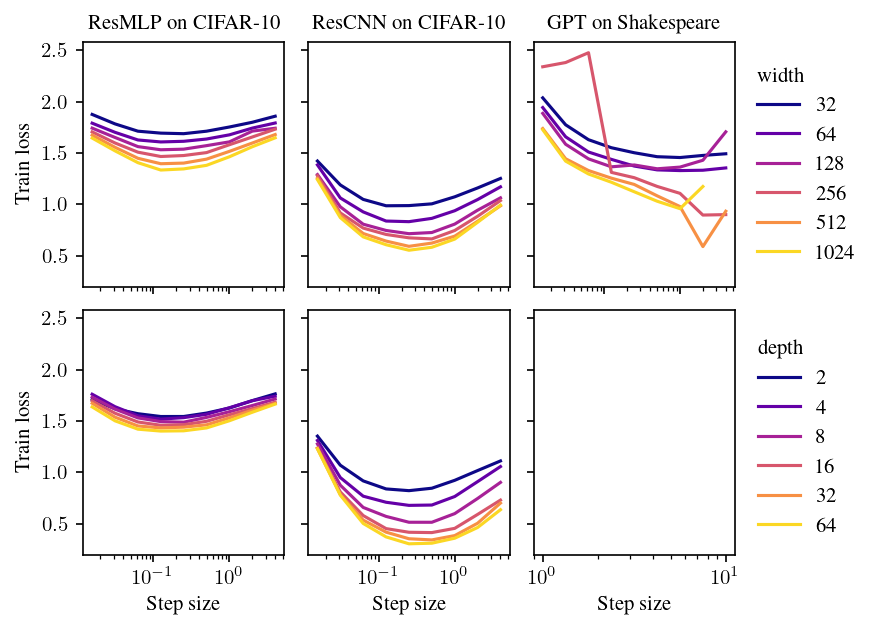

In [4]:
width_list = [32, 64, 128, 256, 512, 1024]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64]; this_width = 128

normalize = "normalize"
key = "train_loss"
# key = "train_acc"
optim = "adam"

fig, axes = plt.subplots(2, 3, sharey=True)
fig.set_figheight(4)

axis = 0
for arch, dataset in ("resmlp","cifar10"), ("rescnn", "cifar10"), ("gpt", "shakespeare"):
    for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
        lr_list, result_list = get_run(dataset, arch, optim, normalize, width, this_depth, key, verbose=False)
        axes[0,axis].plot(lr_list, result_list, color=color, label=width)
        axes[0,axis].set_xscale("log")
        axes[0,axis].set_xticklabels([])
        if arch == "resmlp": title = "ResMLP"
        elif arch == "rescnn": title = "ResCNN"
        elif arch == "gpt": title = "GPT"
        title += " on "
        if dataset == "cifar10": title += "CIFAR-10"
        elif dataset == "shakespeare": title += "Shakespeare"
        axes[0,axis].set_title(title)
    for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
        lr_list, result_list = get_run(dataset, arch, optim, normalize, this_width, depth, key, verbose=False)
        axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
        axes[1,axis].set_xscale("log")
        axes[1,axis].set_xlabel("Step size")
    axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,2].legend(title="width", bbox_to_anchor=(1.7,  0.97))._legend_box.align = "left"
axes[1,2].legend(title="depth", bbox_to_anchor=(1.6,  0.95))._legend_box.align = "left"

# axes[0,0].set_ylim(0.25,2.0)

plt.tight_layout(w_pad=0.8, pad=0.0)
plt.savefig("sweep-arch.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

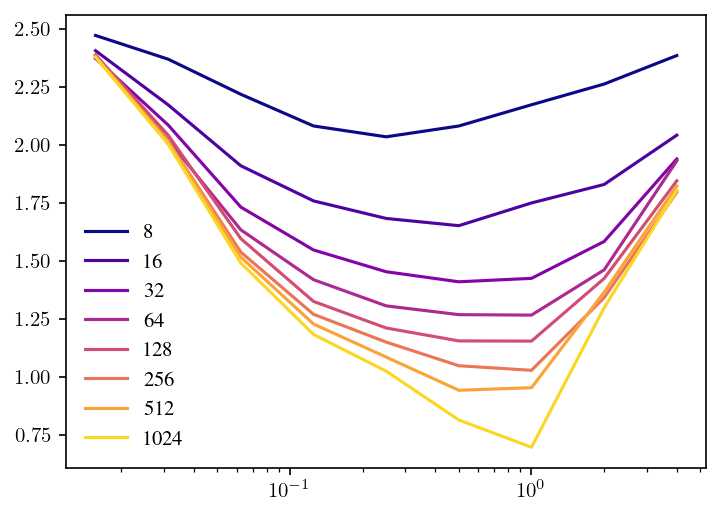

In [5]:
logdir = "../logs/gpt_d_embed_sweep_all_larger_fixed_dim_simplified_sens_1"

width_list = [8, 16, 32, 64, 128, 256, 512, 1024]
lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0]

plt.figure().set_figheight(4)

for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
    returned_result_list = []
    returned_lr_list = []
    
    for lr in lr_list:
        try:
            with open(os.path.join(logdir, str(width), str(lr), 'results.pickle'), "rb") as file:
                results = pickle.load(file)[key]
            average_result = np.mean(results[-50:])
            returned_result_list.append(average_result)
            returned_lr_list.append(lr)
        except:
            print(f"warning: missing width={width} lr={lr}")
    
    plt.plot(returned_lr_list, returned_result_list, label=width, color=color)
plt.xscale("log")
plt.legend()
plt.show()